# Generation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
dfg = pd.read_excel('./data/annual_generation_state.xls')

In [3]:
# Resetting column headings
dfg.columns = dfg.iloc[0]
dfg.drop([0], inplace = True)

In [4]:
dfg.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
1,1990,AK,Total Electric Power Industry,Total,5599506
2,1990,AK,Total Electric Power Industry,Coal,510573
3,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521
4,1990,AK,Total Electric Power Industry,Natural Gas,3466261
5,1990,AK,Total Electric Power Industry,Petroleum,497116


## Generation Data Cleaning and EDA

Energy Information Administration data is quite complete:

In [5]:
dfg.isnull().sum()

0
YEAR                          0
STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

In [6]:
dfg.shape

(51633, 5)

All-caps column names will be difficult to work with, so here we rename:

In [7]:
column_rename = {"YEAR": "Year", 
                 "STATE": "State", 
                 "TYPE OF PRODUCER": "Producer Type",
                 "ENERGY SOURCE": "Source", 
                 "GENERATION (Megawatthours)": "Gen MWh"}

dfg.rename(columns=column_rename, inplace=True)

However not all our data types are as expected. "Year" and "GENERATION (Megawatthours)" are expected to be numeric but they are not. We will convert both these columns to int.

In [8]:
dfg.dtypes

0
Year             object
State            object
Producer Type    object
Source           object
Gen MWh          object
dtype: object

In [9]:
dfg['Gen MWh'] = dfg['Gen MWh'].astype(int)
dfg['Year'] = dfg['Year'].astype(int)

We have 29 years of data, 1990 to 2018, just like our rates data:

In [10]:
dfg['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018])

We have 14 different generation sources (including the Total, which we will explore [below](#1.2.2).

In [11]:
dfg['Source'].unique()

array(['Total', 'Coal', 'Hydroelectric Conventional', 'Natural Gas',
       'Petroleum', 'Wind', 'Wood and Wood Derived Fuels', 'Nuclear',
       'Other Biomass', 'Other Gases', 'Pumped Storage', 'Geothermal',
       'Other', 'Solar Thermal and Photovoltaic'], dtype=object)

### State Categories

There are 54 State categories, which is unexpected and worth investigation:

In [12]:
dfg['State'].nunique()

54

Beyond the 50 states plus DC, we have some blanks (' '), and two total US categories, "US-TOTAL" and "US-Total":

In [13]:
dfg['State'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'US-TOTAL', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', '  ',
       'US-Total'], dtype=object)

All three blank State items represent 0 MWh of generation, which is not meaningful data. We lose nothing by dropping these rows.

In [14]:
dfg.loc[dfg['State'] == "  "]

,Year,State,Producer Type,Source,Gen MWh
20577,2003,,Total Electric Power Industry,Coal,0
20578,2003,,Total Electric Power Industry,Natural Gas,0
20579,2003,,Total Electric Power Industry,Petroleum,0


In [15]:
dfg = dfg[dfg['State'] != "  "]

We should also drop the US-TOTAL / US-Total data. We are not modeling the entire country, so the state data are all we need.

In [16]:
dfg = dfg[dfg['State'] != "US-TOTAL"]
dfg = dfg[dfg['State'] != "US-Total"]

## Preprocessing

We saw above that we have almost 50,000 rows. What we are interested in is 51 states, 29 years, and the 14 different types of electricity generation. So we expect to need a **maximum** row count of: 

$51 * 29 * 14 = 20706$ 

In this section we will confirm that the extra rows are not needed, and remove them.

### Producer Type: Total Electric Power Industry

The data contains a range of Producer Types for each combination of Year, State, and Source of generation:

In [17]:
dfg['Producer Type'].unique()

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Industrial Power',
       'Combined Heat and Power, Commercial Power',
       'Electric Generators, Independent Power Producers',
       'Combined Heat and Power, Electric Power'], dtype=object)

This can be most easily understood by looking at the 20 rows of data data for the state of Alaska in the year 1990:

In [18]:
dfg.head(20)

,Year,State,Producer Type,Source,Gen MWh
1,1990,AK,Total Electric Power Industry,Total,5599506
2,1990,AK,Total Electric Power Industry,Coal,510573
3,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521
4,1990,AK,Total Electric Power Industry,Natural Gas,3466261
5,1990,AK,Total Electric Power Industry,Petroleum,497116
6,1990,AK,Total Electric Power Industry,Wind,0
7,1990,AK,Total Electric Power Industry,Wood and Wood Derived Fuels,151035
8,1990,AK,"Electric Generators, Electric Utilities",Total,4493024
9,1990,AK,"Electric Generators, Electric Utilities",Coal,311960
10,1990,AK,"Electric Generators, Electric Utilities",Hydroelectric Conventional,974521


We are not interested in the various producer types - only the "Total Electric Power Industry" for each Year/State. 

It certainly _appears_ that if we sum up the Gen MWh for each Source in rows 8 - 20, they will equal "Total Electric Power Industry" rows 1-7. 

But that is a rather risky assumption to make for almost 50,000 rows of data. So here we confirm this is true:

In [19]:
# This function will return a pivot table object and the multiindex as a list.
# We will use these to create a "Calculated Total" column to compare with the given "Total" column.
def year_state_pivot(data, index, columns):
    return pd.pivot_table(data=data, index=index, columns=columns, fill_value=0), list(pd.pivot_table(data=data, index=index, columns=columns, fill_value=0).columns)

In [20]:
dfg_pivot, dfg_pivot_cols = year_state_pivot(dfg, ['Year', 'State', 'Source'], 'Producer Type')

Now we will create a "Calculated Total" column, which we can compare with "Total Electric Power Industry" numbers:

In [21]:
dfg_pivot[('Gen MWh', 'Calculated Total')] = sum([dfg_pivot[dfg_pivot_cols[i]] for i in range(0,5)])

In [22]:
# We can see the "Total Electric Power Industry" and "Calculated Total" columns side by side,
# and based on the first few rows, they look promising.
dfg_pivot.head()

0                                                                       Gen MWh  \
Producer Type                         Combined Heat and Power, Commercial Power   
Year State Source                                                                 
1990 AK    Coal                                                          198613   
           Hydroelectric Conventional                                         0   
           Natural Gas                                                        0   
           Petroleum                                                      66920   
           Total                                                         265533   

0                                                                              \
Producer Type                         Combined Heat and Power, Electric Power   
Year State Source                                                               
1990 AK    Coal                                                             0   
           Hydroelectric Conventional                                       0   
           Natural Gas                                                      0   
           Petroleum                                                        0   
           Total                                                            0   

0                                                                                \
Producer Type                         Combined Heat and Power, Industrial Power   
Year State Source                                                                 
1990 AK    Coal                                                               0   
           Hydroelectric Conventional                                         0   
           Natural Gas                                                   596623   
           Petroleum                                                      93291   
           Total                                                         840949   

0                                                                              \
Producer Type                         Electric Generators, Electric Utilities   
Year State Source                                                               
1990 AK    Coal                                                        311960   
           Hydroelectric Conventional                                  974521   
           Natural Gas                                                2869638   
           Petroleum                                                   336905   
           Total                                                      4493024   

0                                                                                       \
Producer Type                         Electric Generators, Independent Power Producers   
Year State Source                                                                        
1990 AK    Coal                                                                      0   
           Hydroelectric Conventional                                                0   
           Natural Gas                                                               0   
           Petroleum                                                                 0   
           Total                                                                     0   

0                                                                    \
Producer Type                         Total Electric Power Industry   
Year State Source                                                     
1990 AK    Coal                                              510573   
           Hydroelectric Conventional                        974521   
           Natural Gas                                      3466261   
           Petroleum                                         497116   
           Total                                            5599506   

0                                                       
Producer Type            

In the cell below, we compare our "Calculated Total" column with the "Total Electric Power Industry" column. By subtracting, taking the absolute value, and counting True/False values, we can see if the generation totals are as we expect. 

We allow a threshold of 10 to account for rounding errors. Out of values that range from the thousands into the millions, this is insignificant:

In [23]:
(abs(dfg_pivot[('Gen MWh', 'Calculated Total')] - dfg_pivot[('Gen MWh', 'Total Electric Power Industry')]) <= 10).value_counts()

True    13809
dtype: int64

We have confirmed that the rows where Producer Type is "Total Electric Power Industry" contain all important information in the other "Producer Type" rows. Here, we will drop all "Producer Type" rows that do not represent "Total Electric Power Industry".

In [24]:
dfg = dfg[dfg['Producer Type'] == 'Total Electric Power Industry']

In [25]:
dfg.shape

(13809, 5)

### Source: Total

We are also interested in the various generation sources. Let's use the function created above to confirm that each "Total" row is equal to the sum of the various generation sources. Again, we can use the data from 1990 for Alaska to demonstrate the expected relationship.

Below, the "Gen MWh" values for Coal, Hydroelectric, Natural Gas, etc. _appear_ to add up to the "Total" row:

In [26]:
dfg.head(7)

,Year,State,Producer Type,Source,Gen MWh
1,1990,AK,Total Electric Power Industry,Total,5599506
2,1990,AK,Total Electric Power Industry,Coal,510573
3,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521
4,1990,AK,Total Electric Power Industry,Natural Gas,3466261
5,1990,AK,Total Electric Power Industry,Petroleum,497116
6,1990,AK,Total Electric Power Industry,Wind,0
7,1990,AK,Total Electric Power Industry,Wood and Wood Derived Fuels,151035


We will use the function created in section 1.2.1 again:

In [27]:
dfg_pivot, dfg_pivot_cols = year_state_pivot(dfg, ['Year', 'State'], 'Source')

In [28]:
# Moving "Total" to the end for readability
dfg_pivot = dfg_pivot[dfg_pivot.columns.set_levels(['Coal', 
                                        'Geothermal',
                                        'Hydroelectric Conventional',
                                        'Natural Gas',
                                        'Nuclear',
                                        'Other',
                                        'Other Biomass',
                                        'Other Gases',
                                        'Petroleum',
                                        'Pumped Storage',
                                        'Solar Thermal and Photovoltaic',
                                        'Wind',
                                        'Wood and Wood Derived Fuels',
                                        'Total'],
                                        level=1)]

In [29]:
dfg_pivot.head()

0            Gen MWh                                                    \
Source          Coal Geothermal Hydroelectric Conventional Natural Gas   
Year State                                                               
1990 AK       510573          0                     974521     3466261   
     AL     53658115          0                   10366507     1020714   
     AR     19207935          0                    3654653     3578573   
     AZ     31915610          0                    7417576     2333900   
     CA      2637677   14521254                   23792567    74168308   

0                                                                              \
Source       Nuclear Other Other Biomass Other Gases Petroleum Pumped Storage   
Year State                                                                      
1990 AK            0     0             0           0    497116              0   
     AL     12051882     0         47503      269476    138089              0   
     AR     11282053     0         15389           0     79979          42972   
     AZ     20597689     0             0           0    151867         249767   
     CA     32692807     0       2117915     2146742   5473852         986252   

0                                                   \
Source     Solar Thermal and Photovoltaic     Wind   
Year State                                           
1990 AK                                 0        0   
     AL                                 0        0   
     AR                                 0        0   
     AZ                                 0        0   
     CA                            366668  2758881   

0                                                  
Source     Wood and Wood Derived Fuels      Total  
Year State                                         
1990 AK                         151035    5599506  
     AL                        2099847   79652133  
     AR                        1238044   39099598  
     AZ                         107888   62774297  
     CA                        4121986  165784909

In [30]:
# Since we reordered our columns we need to reset our multiindex list object:
dfg_pivot_cols = list(dfg_pivot.columns)

In [31]:
dfg_pivot[('Gen MWh', 'Calculated Total')] = sum([dfg_pivot[dfg_pivot_cols[i]] for i in range(0,13)])

In [32]:
dfg_pivot.head()

0            Gen MWh                                                    \
Source          Coal Geothermal Hydroelectric Conventional Natural Gas   
Year State                                                               
1990 AK       510573          0                     974521     3466261   
     AL     53658115          0                   10366507     1020714   
     AR     19207935          0                    3654653     3578573   
     AZ     31915610          0                    7417576     2333900   
     CA      2637677   14521254                   23792567    74168308   

0                                                                              \
Source       Nuclear Other Other Biomass Other Gases Petroleum Pumped Storage   
Year State                                                                      
1990 AK            0     0             0           0    497116              0   
     AL     12051882     0         47503      269476    138089              0   
     AR     11282053     0         15389           0     79979          42972   
     AZ     20597689     0             0           0    151867         249767   
     CA     32692807     0       2117915     2146742   5473852         986252   

0                                                   \
Source     Solar Thermal and Photovoltaic     Wind   
Year State                                           
1990 AK                                 0        0   
     AL                                 0        0   
     AR                                 0        0   
     AZ                                 0        0   
     CA                            366668  2758881   

0                                                                   
Source     Wood and Wood Derived Fuels      Total Calculated Total  
Year State                                                          
1990 AK                         151035    5599506          5599506  
     AL                        2099847   79652133         79652133  
     AR                        1238044   39099598         39099598  
     AZ                         107888   62774297         62774297  
     CA                        4121986  165784909        165784909

We before we compare our Calculated Total with the existing total, with a rounding error tolerance of 10. And we again confirm our assumptions about the data:

In [33]:
(abs(dfg_pivot[('Gen MWh', 'Calculated Total')] - dfg_pivot[('Gen MWh', 'Total')]) <= 10).value_counts()

True    1479
dtype: int64

## Pivoting and Final Consolidation

Our pivot tables have served their purpose. We now return to the main "dfg" dataframe:

In [34]:
dfg.head()

,Year,State,Producer Type,Source,Gen MWh
1,1990,AK,Total Electric Power Industry,Total,5599506
2,1990,AK,Total Electric Power Industry,Coal,510573
3,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521
4,1990,AK,Total Electric Power Industry,Natural Gas,3466261
5,1990,AK,Total Electric Power Industry,Petroleum,497116


Since "Producer Type" only contains "Total Electric Power Industry" we can drop that column:

In [35]:
dfg.drop(columns=['Producer Type'], inplace=True)

Let's shorten some of the Source names:

In [36]:
dfg.replace({"Source": {"Hydroelectric Conventional": "Hydroelectric", 
                        "Solar Thermal and Photovoltaic": "Solar Thermal/PV"}}, inplace=True)

Now we do a final pivot our dataframe, so each Year / State combination is a row, and each generation source is a column with Gen MWh as the value:

In [37]:
dfg = pd.pivot_table(data=dfg,index=["Year", "State"], columns = "Source", values = "Gen MWh", fill_value=0)
dfg.reset_index(level=[0,1], inplace = True)
dfg.head()

Source,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Biomass,Other Gases,Petroleum,Pumped Storage,Solar Thermal/PV,Total,Wind,Wood and Wood Derived Fuels
0,1990,AK,510573,0,974521,3466261,0,0,0,0,497116,0,0,5599506,0,151035
1,1990,AL,53658115,0,10366507,1020714,12051882,0,47503,269476,138089,0,0,79652133,0,2099847
2,1990,AR,19207935,0,3654653,3578573,11282053,0,15389,0,79979,42972,0,39099598,0,1238044
3,1990,AZ,31915610,0,7417576,2333900,20597689,0,0,0,151867,249767,0,62774297,0,107888
4,1990,CA,2637677,14521254,23792567,74168308,32692807,0,2117915,2146742,5473852,986252,366668,165784909,2758881,4121986


The "Other Biomass" and "Wood and Wood Derived Fuels" can be combined into one column, "Biomass", and then we can drop them.

In [38]:
dfg["Biomass"] = dfg["Wood and Wood Derived Fuels"] + dfg["Other Biomass"]
dfg.drop(["Wood and Wood Derived Fuels", "Other Biomass"], axis = 1, inplace = True)

"Pumped Storage" is an energy storage technology. While energy storage is an important subject, it is beyond the scope of this project. Rather than include it as a generation source, we will drop the column.

**Note:** This will result in states with significant pumped storage to have generation totals slightly off 100%. Rather than adjust the generation totals to hide this, I choose to leave them as is. This will be visible in the stackplot visualizations, where a few states may have a generation total slightly below or above 100%. 

In [39]:
dfg.drop(columns=['Pumped Storage'], inplace=True)

Changing our float display format will make the data easier to interpret visually:

In [40]:
pd.options.display.float_format = '{:,.0f}'.format

In [41]:
dfg.head()

Source,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Gases,Petroleum,Solar Thermal/PV,Total,Wind,Biomass
0,1990,AK,510573,0,974521,3466261,0,0,0,497116,0,5599506,0,151035
1,1990,AL,53658115,0,10366507,1020714,12051882,0,269476,138089,0,79652133,0,2147350
2,1990,AR,19207935,0,3654653,3578573,11282053,0,0,79979,0,39099598,0,1253433
3,1990,AZ,31915610,0,7417576,2333900,20597689,0,0,151867,0,62774297,0,107888
4,1990,CA,2637677,14521254,23792567,74168308,32692807,0,2146742,5473852,366668,165784909,2758881,6239901


Save the pre-processed electricity generation dataframe to .csv:

In [42]:
dfg.to_csv('./data/electricity-generation.csv')

# Rates Data

## Importing Data from EIA Source .xls(x) files

In [43]:
dfr = pd.read_excel('./data/avgprice_annual.xlsx', header=1)

In [44]:
dfr.head()

,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total
0,2018,AK,Total Electric Industry,22,19,17,0,nan,19
1,2018,AL,Total Electric Industry,12,11,6,0,nan,10
2,2018,AR,Total Electric Industry,10,8,6,11,nan,8
3,2018,AZ,Total Electric Industry,13,11,7,10,nan,11
4,2018,CA,Total Electric Industry,19,16,13,9,nan,17


In [45]:
dfr.shape

(4271, 9)

## Initial Data Cleaning

There are nulls in some of the electricity rates data, but not in the Total column, and that is the one we will use, so these are not a problem.

In [46]:
dfr.isnull().sum()

Year                           0
State                          0
Industry Sector Category       0
Residential                    0
Commercial                     0
Industrial                     0
Transportation              1607
Other                       2664
Total                          0
dtype: int64

In [47]:
dfr.dtypes

Year                          int64
State                        object
Industry Sector Category     object
Residential                 float64
Commercial                  float64
Industrial                  float64
Transportation              float64
Other                       float64
Total                       float64
dtype: object

In [48]:
# Reverse row order of the dataframe to match time, 1990 to 2018
dfr.sort_values('Year', inplace=True, ascending=True)
dfr.head()

,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total
4270,1990,US,Full-Service Providers,8,7,5,nan,6,7
4194,1990,NC,Total Electric Industry,8,6,5,nan,7,6
4195,1990,ND,Total Electric Industry,6,6,5,nan,4,6
4196,1990,NE,Total Electric Industry,6,6,4,nan,6,6
4197,1990,NH,Total Electric Industry,10,10,7,nan,13,9


We're going to focus on overall electricity costs, represented by the "Total" columns, so we will drop the remaining columns. This has the added benefit of removing all null values. Thank you EIA for such clean data!

In [49]:
dfr.drop(columns = ['Residential', 'Commercial', 'Industrial', 'Transportation', 'Other'],inplace = True)

The "Total" column expresses the total cents per kWh, so let's rename it to something meaningful.

In [50]:
dfr.rename({"Total": "Cents_kWh"}, axis=1, inplace=True)

In [51]:
dfr.isnull().sum()

Year                        0
State                       0
Industry Sector Category    0
Cents_kWh                   0
dtype: int64

From "Industrial Sector Category, what we're interested in is "Total Electric Industry" so we'll drop the rows which represent the categories, which are merely constituents of the total. We do not need the "Industry Sector Category" column now, as that column only has one value, "Total Electric Industry". And we'll sort by year and state, and reset the index.

In [52]:
dfr = dfr[dfr['Industry Sector Category'] == "Total Electric Industry"]

In [53]:
dfr.drop(axis = 1, columns = ["Industry Sector Category"], inplace = True)

In [54]:
dfr.sort_values(by = ['Year', 'State'], inplace = True)

We need to drop all "State" rows that represent the whole US. Keeping that aggregate row per year could distort our data as we're focusing on individual states:

In [55]:
dfr = dfr[dfr["State"] != "US"]

In [56]:
dfr.reset_index(drop = True)

,Year,State,Cents_kWh
0,1990,AK,9
1,1990,AL,6
2,1990,AR,7
3,1990,AZ,8
4,1990,CA,9
...,...,...,...
1474,2018,VT,15
1475,2018,WA,8
1476,2018,WI,11
1477,2018,WV,9


## Confirming we have the same number of entries per state (incl. DC, 51). <br>
Without displaying the entire series, 1479 / 51 = 29, and that is what we have.

In [57]:
dfr['Year'].value_counts().sort_index().head()

1990    51
1991    51
1992    51
1993    51
1994    51
Name: Year, dtype: int64

In [58]:
dfr['State'].value_counts().sort_index().head()

AK    29
AL    29
AR    29
AZ    29
CA    29
Name: State, dtype: int64

## EDA - Visualization

For each year we will create a boxplot. Each individual boxplot will display the distribution of electricity rates across all the states for the year in question. These can all be displayed on one plot.

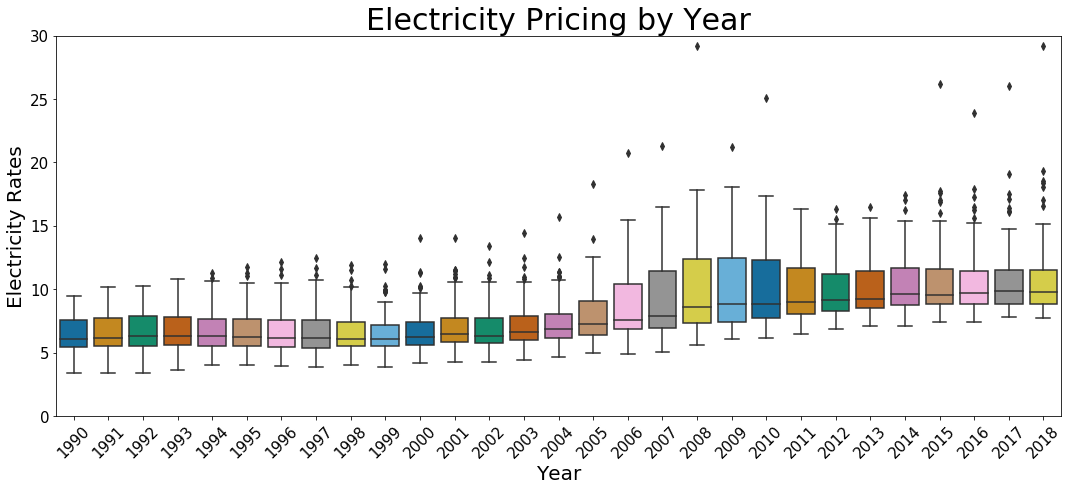

In [59]:
plt.figure(figsize=(18, 7))
plt.ylim(0,30)  # If we don't set y limit our plot starts around 2 which makes prices look artificially low
ax = sns.boxplot(y = "Cents_kWh", x = "Year", data=dfr, orient='v', palette="colorblind");
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_title("Electricity Pricing by Year",fontsize=30);
ax.set_xlabel("Year",fontsize=20);
ax.set_ylabel("Electricity Rates",fontsize=20);
ax.tick_params(labelsize=15)

**Interpretation:** each individual box left to right represents the range of retail electricity prices for all 50 states plus Puerto Rico and Washington DC. 

**_But this is not an accurate picture._** Per the EIA's website, prices have **not** been adjusted to remove the effects of inflation:

https://www.eia.gov/tools/faqs/faq.php?id=13&t=5

Fortunately there is a python library published by the Los Angeles Times Data and Graphics Department which will help us solve this problem:

https://github.com/datadesk/cpi

Below, we will install the package and adjust our data for inflation:

**NOTE - the install code is commented out deliberately. Uncomment the cell below to install CPI.**

## Adjusting Rates for Inflation

In [60]:
#pip install cpi
#cpi.update()

Here the CPI library is imported, a function is defined to adjust our rates data for inflation, and it is applied to the entire dataframe:

In [61]:
import cpi

In [62]:
def inflate(row):
    return cpi.inflate(row['Cents_kWh'], row['Year'], to=2005)

In [63]:
dfr['Cents_kWh_Inf_Adj'] = np.round(dfr.apply(inflate, axis = 1), 2)

We no longer need the pre-inflation adjusted "Total" column:

In [64]:
dfr.drop(columns = "Cents_kWh", inplace = True)

In [65]:
dfr.head()

,Year,State,Cents_kWh_Inf_Adj
4167,1990,AK,14
4168,1990,AL,8
4169,1990,AR,10
4170,1990,AZ,12
4171,1990,CA,13


## Post-Adjustment EDA

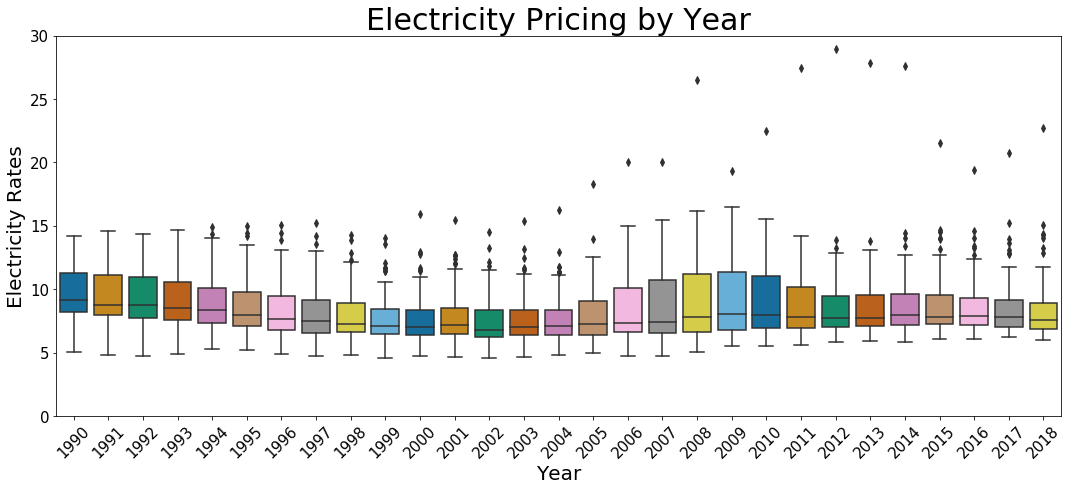

In [66]:
plt.figure(figsize=(18, 7))
plt.ylim(0,30)  # If we don't set y limit our plot starts around 2 which makes prices look artificially low
ax = sns.boxplot(y = "Cents_kWh_Inf_Adj", x = "Year", data=dfr, orient='v', palette="colorblind");
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_title("Electricity Pricing by Year",fontsize=30);
ax.set_xlabel("Year",fontsize=20);
ax.set_ylabel("Electricity Rates",fontsize=20);
ax.tick_params(labelsize=15) 

**Interpretation:** The CPI adjusted data shows an overall decline in electricity rates nationwide, starting in 1990 to around 2003, with a clear outlier starting in 2000. It turns out that is Hawaii:

## Identifying Outlier

In [67]:
#Instantiate a "number one!" dataframe:
dfr_num_1 = pd.DataFrame()

In [68]:
# Collect our highest electricity price:
for i in range(2000, 2019):
    dfr_num_1 = pd.concat([dfr_num_1, dfr[dfr['Year'] == i].nlargest(1, "Cents_kWh_Inf_Adj")])

In [69]:
# Hawaii breaks away from the pack in 2000 - something worth investigating!
dfr_num_1

,Year,State,Cents_kWh_Inf_Adj
3000,2000,HI,16
2836,2001,HI,15
2675,2002,HI,15
2514,2003,HI,15
2346,2004,HI,16
2179,2005,HI,18
2012,2006,HI,20
1845,2007,HI,20
1675,2008,HI,26
1505,2009,HI,19


## Saving to .csv

In [70]:
dfr.to_csv('./data/electricity-rates.csv')